<a href="https://colab.research.google.com/github/cbadenes/curso-pln/blob/main/notebooks/02_regresion_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de Reseñas de Restaurantes usando Regresión Logística

Este notebook muestra cómo implementar un clasificador de regresión logística para categorizar reseñas de restaurantes según su valoración.

## 1. Configuración del Entorno

In [1]:
# Importar bibliotecas necesarias
import json
import pandas as pd
import numpy as np
from collections import Counter
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

## 2. Cargar y Preparar los Datos

In [2]:
# Cargar datos desde GitHub
url = "https://raw.githubusercontent.com/cbadenes/curso-pln/main/datasets/valoraciones_restaurante.json"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data['reviews'])

def simplificar_rating(rating):
    if rating <= 2:
        return 'negativo'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positivo'

# Añadir columna de sentimiento
df['sentimiento'] = df['rating'].apply(simplificar_rating)

print("Distribución de ratings:")
print(df['rating'].value_counts().sort_index())
print("\nDistribución de sentimientos:")
print(df['sentimiento'].value_counts())

Distribución de ratings:
rating
1     6
2    19
3    24
4    26
5    25
Name: count, dtype: int64

Distribución de sentimientos:
sentimiento
positivo    51
negativo    25
neutral     24
Name: count, dtype: int64


## 3. Preparar los Datos para Regresión Logística

In [3]:
def dividir_datos(df, train_size=0.7, val_size=0.15):
    """
    Divide los datos en conjuntos de entrenamiento, validación y test
    """
    # Crear copia del DataFrame
    df = df.copy()

    # Mezclar los datos
    indices = np.random.permutation(len(df))

    # Calcular puntos de división
    train_end = int(len(df) * train_size)
    val_end = int(len(df) * (train_size + val_size))

    # Crear índices para cada conjunto
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    # Crear DataFrames para cada conjunto
    train_data = pd.DataFrame(df.iloc[train_indices]).reset_index(drop=True)
    val_data = pd.DataFrame(df.iloc[val_indices]).reset_index(drop=True)
    test_data = pd.DataFrame(df.iloc[test_indices]).reset_index(drop=True)

    print("Tamaño de los conjuntos:")
    print(f"Entrenamiento: {len(train_data)} reseñas")
    print(f"Validación: {len(val_data)} reseñas")
    print(f"Test: {len(test_data)} reseñas")

    return train_data, val_data, test_data

# Dividir los datos
train_data, val_data, test_data = dividir_datos(df)

Tamaño de los conjuntos:
Entrenamiento: 70 reseñas
Validación: 15 reseñas
Test: 15 reseñas


## 4. Vectorización usando frecuencias de palabras

In [4]:
def preparar_vectorizador(textos_entrenamiento):
    """
    Prepara el vectorizador TF-IDF
    """
    vectorizer = TfidfVectorizer(
        min_df=2,  # Ignorar términos que aparecen en menos de 2 documentos
        max_df=0.95,  # Ignorar términos que aparecen en más del 95% de los documentos
        stop_words=['el', 'la', 'los', 'las', 'un', 'una', 'unos', 'unas', 'y', 'o', 'pero'],
        ngram_range=(1, 2)  # Considerar unigramas y bigramas
    )

    # Ajustar el vectorizador
    vectorizer.fit(textos_entrenamiento)

    print(f"Tamaño del vocabulario: {len(vectorizer.vocabulary_)}")
    print("\nAlgunas características del vocabulario:")
    print(list(vectorizer.vocabulary_.keys())[:10])

    return vectorizer

# Preparar vectorizador y transformar datos
vectorizer = preparar_vectorizador(train_data['text'])
X_train = vectorizer.transform(train_data['text'])
X_val = vectorizer.transform(val_data['text'])
X_test = vectorizer.transform(test_data['text'])

# Preparar etiquetas
y_train = train_data['sentimiento']
y_val = val_data['sentimiento']
y_test = test_data['sentimiento']

Tamaño del vocabulario: 284

Algunas características del vocabulario:
['restaurante', 'antigua', 'real', 'paella', 'fresco', 'ambiente', 'era', 'muy', 'acogedor', 'vistas']


## 5. Entrenar el Modelo de Regresión Logística

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Reporte de clasificación - Entrenamiento:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00        17
     neutral       1.00      1.00      1.00        19
    positivo       1.00      1.00      1.00        34

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



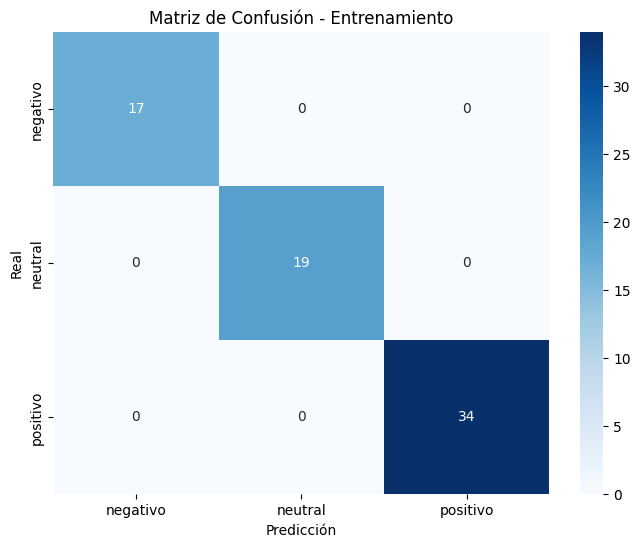


Reporte de clasificación - Validación:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00         4
     neutral       1.00      1.00      1.00         1
    positivo       1.00      1.00      1.00        10

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



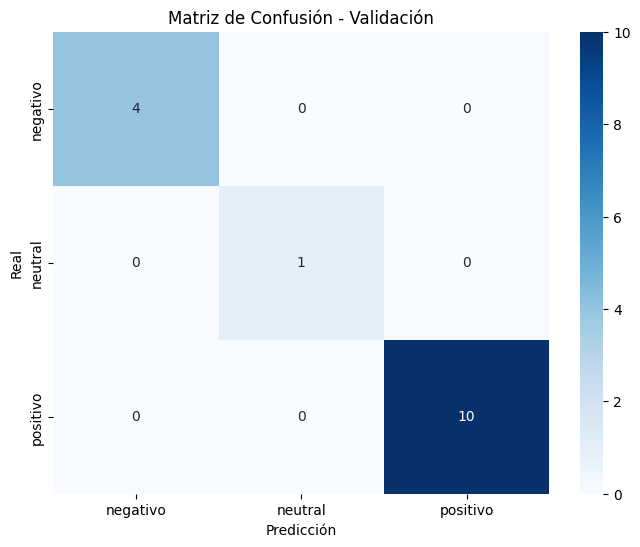


Reporte de clasificación - Test:
              precision    recall  f1-score   support

    negativo       1.00      1.00      1.00         4
     neutral       1.00      1.00      1.00         4
    positivo       1.00      1.00      1.00         7

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



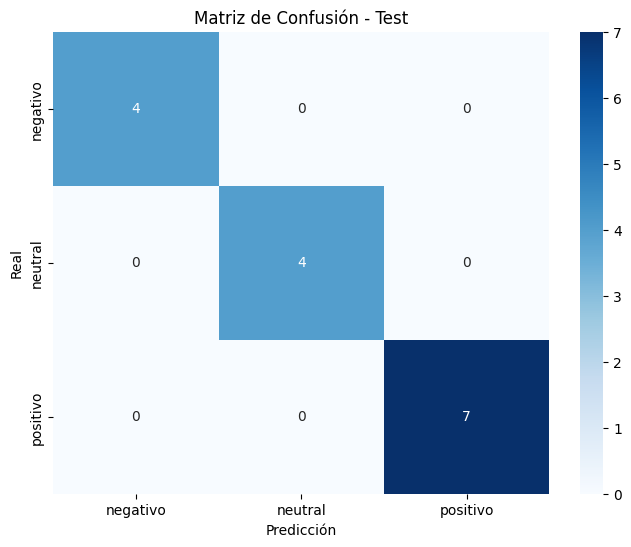

In [5]:
# Crear y entrenar el modelo
modelo = LogisticRegression(
    multi_class='multinomial',  # Para clasificación multiclase
    solver='lbfgs',  # Optimizador
    max_iter=1000,  # Máximo de iteraciones
    random_state=42  # Para reproducibilidad
)

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Funciones de evaluación
def evaluar_modelo(modelo, X, y, nombre_conjunto):
    """
    Evalúa el modelo y muestra métricas detalladas
    """
    # Realizar predicciones
    y_pred = modelo.predict(X)

    # Mostrar reporte de clasificación
    print(f"\nReporte de clasificación - {nombre_conjunto}:")
    print(classification_report(y, y_pred))

    # Mostrar matriz de confusión
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negativo', 'neutral', 'positivo'],
                yticklabels=['negativo', 'neutral', 'positivo'])
    plt.title(f'Matriz de Confusión - {nombre_conjunto}')
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.show()

# Evaluar en cada conjunto
evaluar_modelo(modelo, X_train, y_train, "Entrenamiento")
evaluar_modelo(modelo, X_val, y_val, "Validación")
evaluar_modelo(modelo, X_test, y_test, "Test")

## 6. Análisis de Características Importantes

In [6]:
def analizar_caracteristicas_importantes(modelo, vectorizer, n=10):
    """
    Analiza las características más importantes para cada clase
    """
    # Obtener nombres de características
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Para cada clase
    for i, clase in enumerate(modelo.classes_):
        print(f"\nPalabras más importantes para clase '{clase}':")

        # Obtener coeficientes para esta clase
        coefs = modelo.coef_[i]

        # Obtener índices de los coeficientes más grandes (positivos)
        top_positive = np.argsort(coefs)[-n:]

        # Mostrar palabras y sus coeficientes
        for idx in reversed(top_positive):
            print(f"{feature_names[idx]}: {coefs[idx]:.4f}")

# Analizar características importantes
analizar_caracteristicas_importantes(modelo, vectorizer)


Palabras más importantes para clase 'negativo':
no: 0.7985
no lo: 0.7985
lo recomendamos: 0.7985
lo: 0.7985
recomendamos: 0.7985
fría no: 0.3059
muy limitada: 0.2705
limitada: 0.2705
muy lento: 0.2619
lento: 0.2619

Palabras más importantes para clase 'neutral':
aceptable: 0.7754
varios aspectos: 0.7754
mejorar en: 0.7754
mejorar: 0.7754
podría mejorar: 0.7754
estaba aceptable: 0.7754
aspectos: 0.7754
varios: 0.7754
podría: 0.7754
en: 0.7754

Palabras más importantes para clase 'positivo':
volveremos: 0.7430
definitivamente: 0.7430
definitivamente volveremos: 0.7430
calidad: 0.3706
excelente: 0.3185
original definitivamente: 0.2991
son espectaculares: 0.2689
vistas: 0.2689
espectaculares: 0.2689
vistas son: 0.2689


## 7. Predicción de Nuevas Reseñas

In [7]:
def predecir_sentimiento(texto, modelo, vectorizer):
    """
    Predice el sentimiento de una nueva reseña
    """
    # Vectorizar el texto
    X = vectorizer.transform([texto])

    # Obtener predicción y probabilidades
    prediccion = modelo.predict(X)[0]
    probabilidades = modelo.predict_proba(X)[0]

    print(f"Texto: {texto}")
    print(f"Predicción: {prediccion}")
    print("\nProbabilidades:")
    for clase, prob in zip(modelo.classes_, probabilidades):
        print(f"{clase}: {prob:.2f}")

# Ejemplo de uso
nueva_resena = "Restaurante Prueba: La comida estaba deliciosa y el servicio fue excelente. Los precios son muy razonables."
predecir_sentimiento(nueva_resena, modelo, vectorizer)

Texto: Restaurante Prueba: La comida estaba deliciosa y el servicio fue excelente. Los precios son muy razonables.
Predicción: positivo

Probabilidades:
negativo: 0.29
neutral: 0.17
positivo: 0.54


## 8. Evaluación con Reseñas Ambiguas


Evaluación en reseñas ambiguas:

Reporte de clasificación - Reseñas Ambiguas:
              precision    recall  f1-score   support

    negativo       0.00      0.00      0.00         2
     neutral       0.00      0.00      0.00         1
    positivo       0.33      0.50      0.40         2

    accuracy                           0.20         5
   macro avg       0.11      0.17      0.13         5
weighted avg       0.13      0.20      0.16         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


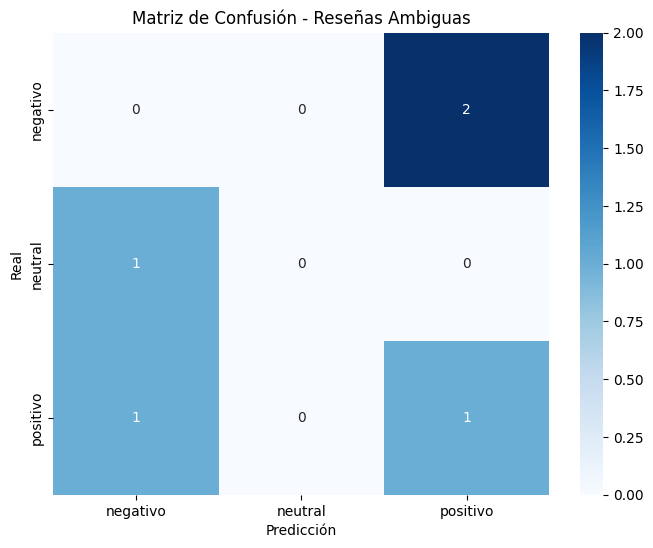

In [8]:
reseñas_ambiguas = [
    {
        "id": 101,
        "rating": 4,
        "text": "Restaurante La Paradoja: La comida estaba fría y mal presentada, pero los sabores eran extraordinarios y el chef se disculpó personalmente. Los precios son altos pero vale la pena por la originalidad de los platos."
    },
    {
        "id": 102,
        "rating": 2,
        "text": "Bistró El Contraste: El servicio fue impecable y el local es precioso, pero la calidad de la comida fue terrible. A pesar del ambiente maravilloso, no podemos dar más que una mala valoración por lo principal: la comida."
    },
    {
        "id": 103,
        "rating": 3,
        "text": "Cafetería La Duda: Los pasteles son exquisitos y el café horrible. El personal es amable pero extremadamente lento. El local está limpio pero necesita renovación. No sé si recomendarlo o no."
    },
    {
        "id": 104,
        "rating": 5,
        "text": "Bar El Misterio: El local es pequeño y ruidoso, el servicio algo lento, pero la comida es tan espectacular que compensa todo lo demás. Los precios son excesivos aunque repetiremos sin duda."
    },
    {
        "id": 105,
        "rating": 1,
        "text": "Restaurante La Confusión: A pesar de la excelente ubicación y la decoración elegante, todo lo demás fue un desastre. Ni siquiera los precios económicos compensan la pésima experiencia."
    }
]

# Crear DataFrame con las reseñas ambiguas
df_ambiguo = pd.DataFrame(reseñas_ambiguas)
df_ambiguo['sentimiento'] = df_ambiguo['rating'].apply(simplificar_rating)

# Vectorizar reseñas ambiguas
X_ambiguo = vectorizer.transform(df_ambiguo['text'])
y_ambiguo = df_ambiguo['sentimiento']

# Evaluar en reseñas ambiguas
print("\nEvaluación en reseñas ambiguas:")
evaluar_modelo(modelo, X_ambiguo, y_ambiguo, "Reseñas Ambiguas")